In [448]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from GPy.mappings.constant import Constant
import GPy
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['lines.linestyle'] = ' '
mpl.rcParams['lines.marker'] = '.'
import matplotlib.cm as cm

## Generate dummy ground-truth

In [449]:
k = GPy.kern.RBF(1, variance=7., lengthscale=0.2)
np.random.seed(4)
# input locations
N = 200
X = np.random.uniform(0,1,N).reshape(-1,1)
# latent values $f$ at the inputs (sample from GP prior)
f = np.random.multivariate_normal(np.zeros(N), k.K(X))
# squash latent values through probit function (default link for bernoulli lieklyhood) to get probabilities
lik = GPy.likelihoods.Bernoulli()
p = lik.gp_link.transf(f)
# use probabilites to generate bernoully draws (observations y are expected to be bernoulli distributed with probabilitis p)
y = np.random.binomial(n=1, p=p, size=N).reshape(-1,1)

(-3, 4)

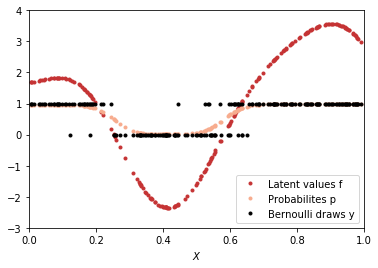

In [450]:
plt.plot(X,f, label='Latent values f', color=cm.coolwarm(0.95))
plt.plot(X,p, label='Probabilites p', color=cm.coolwarm(0.7))
plt.plot(X,y, label='Bernoulli draws y', color='k')
plt.xlabel('$X$')
plt.legend()
plt.xlim(0,1)
plt.ylim(-3,4)

## Inference

Given only the observations (X,y), the latent functions f(X) (including the hyperparameters of the kernel) should be found

In [451]:
def plot_model(m):
    color = None
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    m.plot_mean(ax=ax[0], plot_raw=True, color=color, label='$f$')
    m.plot_confidence(ax=ax[0], plot_raw=True, color=color, label='95% Confidence region')
    m.plot_mean(ax=ax[1], plot_raw=False, color=color, label='sigmoid($f$)')
    m.plot_data(ax=ax[1], color='k', label='Observed data $y$')
    ax[0].plot(X, f, label='True $f$', c=cm.coolwarm(0.95))
    ax[1].plot(X, p, label='True $p$', c=cm.coolwarm(0.95))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylim(-3,4)
    ax[0].set_title('in domain of latent values')
    ax[1].set_title('in domain of probabilites')

In [452]:
# Explicit instantiation of model -> allows to pass kernel, likelyhood etc...
"""
m = GPy.core.GP(X=X,
                Y=y,
                kernel=k, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)
""";

GPy.models.gp_classification.GPClassification

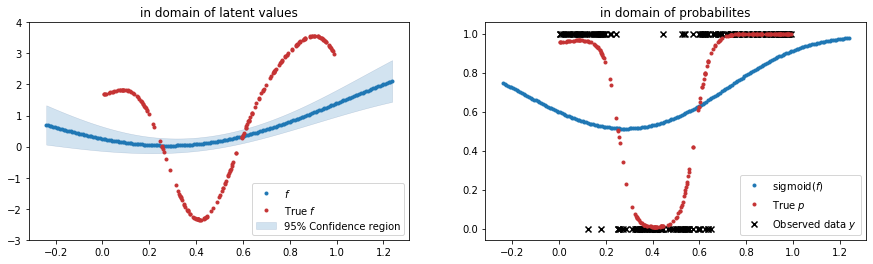

In [454]:
# Shorthand instantiation for a binary classification-model with rbf(1,1), bernoulli-likelyhood and EP
m = GPy.models.GPClassification(X,y,mean_function=Constant(1,1,0.5))
plot_model(m)
m.predict(np.linspace(0,1.2,20).reshape(-1,1), include_likelihood=True)
type(m)

_True_ kernel hyperparameters used to generate the dummy observations are: $\sigma^2 = 7, l = 0.2$

The default classification model above however uses $\sigma^2 = 1, l = 1$. The small variance does not allow the $f$ to deviate much from 0 in general. The higher lengthscale constrains the flexibilty (curvature) too much.

Increasing only the variance allows more deviation, but not yet enough _curvature_:

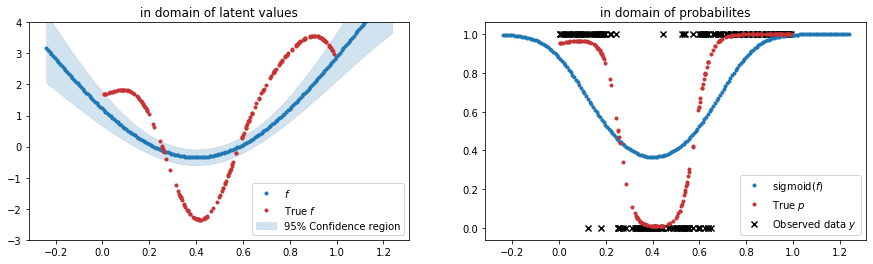

In [456]:
plot_model(GPy.models.GPClassification(X,y, kernel=GPy.kern.RBF(1, variance=7, lengthscale=1), mean_function=Constant(1,1,0.5)))

Decreasing just the length-scale to the _true_ of 0.2 value already results in a quite good fit. However in the latent value domain we see that at the peaks the mean underestimates the true latent values because of the too small variance.

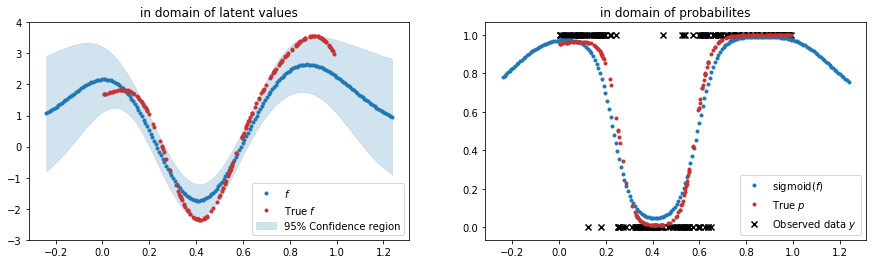

In [457]:
plot_model(GPy.models.GPClassification(X,y, kernel=GPy.kern.RBF(1, variance=1, lengthscale=0.2), mean_function=Constant(1,1,0.5)))

Using the _true_ values for both, the variance and the lengthscale:

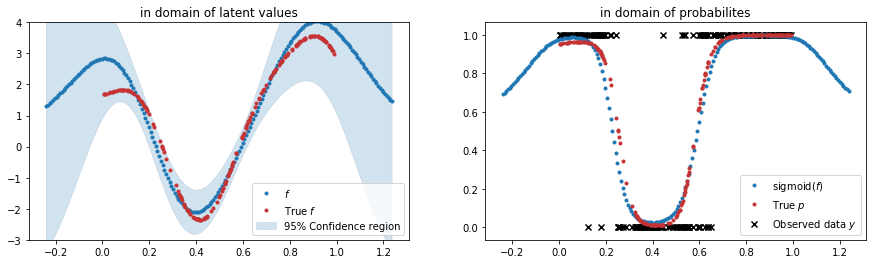

In [459]:
plot_model(GPy.models.GPClassification(X,y, kernel=GPy.kern.RBF(1, variance=7., lengthscale=0.2), mean_function=Constant(1,1,0.5)))

This gives already a quite good fit. However it still seems not perfect... But keep __attention__! Our $f$ is only one possible realization of the GP. I.e. it is sampled by a zero mean GP with rbf(7,0.2) kernel. Therefore, this single sample does not reflect the mean and a perfect fit should not be expected _by design_! It might well be possible that $f$ is sampled by rbf(7,0.2) but would be more likely under rbf(2,0.3).

This can be shown easily for a 1D gaussian distributed random variable:

In [460]:
from scipy.stats import norm
np.random.seed(2)
sampling_params = (0,7)
other_params = (0,3)
z = np.random.normal(*sampling_params)
print('sampled value: %.2f\nprobability under sampling params: %.2f\nprobability under other params: %.2f' % (z, norm(*sampling_params).pdf(z), norm(*other_params).pdf(z)))

sampled value: -2.92
probability under sampling params: 0.05
probability under other params: 0.08


For this particular sampled value of $-2.9$ the _optimal_ params which result in the highest probabilty density would be $(-2.9, v)$ for any fixed $v > 0$ i.e:

$\text{argmax}_\mu P(z | \mu, v) = -2.91$

### Optimize hyperparameters

Starting from the default rbf(1,1) we will now optimize the hyperparameters iteratively:

In [461]:
m = GPy.models.GPClassification(X,y, mean_function=Constant(1,1,0.5))
for i in range(10):
    print('Iteration %2i: variance=%.2f, lengthscale=%.2f' % (i, m.rbf.variance.values[0], m.rbf.lengthscale.values[0]))
    m.optimize('bfgs', max_iters=100) #first runs EP to approximate the posterior, then optimizes the kernel parameters

Iteration  0: variance=1.00, lengthscale=1.00
Iteration  1: variance=1.45, lengthscale=0.20
Iteration  2: variance=4.54, lengthscale=0.22
Iteration  3: variance=6.27, lengthscale=0.23
Iteration  4: variance=6.94, lengthscale=0.24
Iteration  5: variance=7.14, lengthscale=0.24
Iteration  6: variance=7.21, lengthscale=0.24
Iteration  7: variance=7.21, lengthscale=0.24
Iteration  8: variance=7.24, lengthscale=0.24
Iteration  9: variance=7.24, lengthscale=0.24


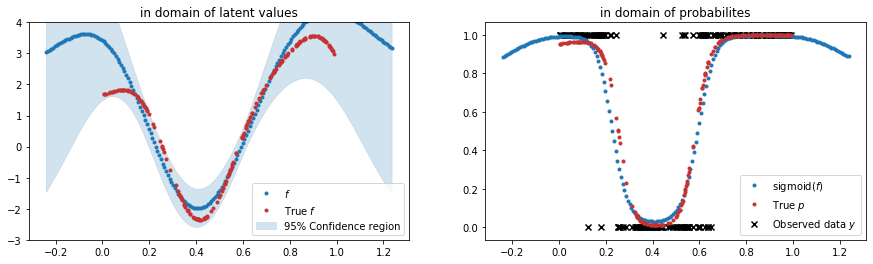

In [462]:
plot_model(m)

The found _optimal_ hyperparameters are rbf(9.77, 0.26) compared to the true rbf(7.00,0.20). The deviation is not huge, but it is still there.

However one can show that the observed $y$ are in fact better explained by those found parameters instead of the _true_ ones. This is done by the concept of __marginal likelihood__. Here we sampled the $f$ from the GP prior (which incorporates kernel and kernel hyperparameters) and then based on $f$ we sampled again $y$ to get the observed dummy data.

In reality $f$ is and can never be observed. To calcualte the likelihood of the (noisy) observed $y$ under the GP prior $f$ has to be _integrated out_. This means for every possible (infinitely many) value of $f$ we take the likelihood of the observed data under this $f$ and weight it according to the probablity of $f$ under the GP prior:

$$
\int_f P(y | f) P(f) \text{d}f = P(y)
$$

For Gaussian Process Regression (with Gaussian Likelihood) this integral can be solved analytically. For Classification there exist several approximation techniques (Laplace, EP).

Hyperparameter optimiziation in GP consists of maximizing the marginal likelihood w.r.t to the hyperparameters. One can show, that the log marginal likelihood consists of a data-fit as well as a complexity-penalty term and has therefore built-in regularization. For intuition consider the following:

The hyperparameters of a kernel specify the models capacity (for example a large length-scale constraints flexibility of hidden function). $P(y)$ is itself a Probability distribution over datasets. Therefore integrating over all possible observed datasets it should sum up to 1. Now assume for the moment our observed data has an _average_ complexity. If we have a very complex model which is able to fit every possible dataset equally well, then $P(y)$ would be uniform (broad an low) i.e. $ 1/ \text{# possible datasets} $ for ever $y$. If the model is very simple, i.e. it can only fit some very _simple_ datasets, then $P(y)$ for our model will be very low due to underfitting. However if we find a model which has just the right complexity for our dataset then $P(y)$ should achieve its maximum. Increasing the complexity would spend probability mass on datasets which are more complex than our observed and (because the total mass is bounded by 1) decrease the probabilty for our dataset. Decreasing the model complexity will also decrease $P(y)$ because the fit gets worse.

### Plot the marginal likelihood for both models:

In [464]:
m_default = GPy.models.GPClassification(X,y, mean_function=Constant(1,1,0.5))
m_true = GPy.models.GPClassification(X,y, kernel=GPy.kern.RBF(1, variance=7., lengthscale=0.2), mean_function=Constant(1,1,0.5))
m_found = GPy.models.GPClassification(X,y, kernel=GPy.kern.RBF(1, variance=9.77, lengthscale=0.26), mean_function=Constant(1,1,0.5))

In [465]:
print('Marginal Likelihood for:\nbaseline rbf(1,1): %.2f\ntrue rbf(7,0.2): %.2f\nfound rbf(9.77,0.25): %.2f' % (m_default.log_likelihood(), m_true.log_likelihood(), m_found.log_likelihood()))

Marginal Likelihood for:
baseline rbf(1,1): -115.50
true rbf(7,0.2): -49.97
found rbf(9.77,0.25): -49.87
